In [2]:
#Kolminkertainen eksponentiaalinen tasoitus
#Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.
#Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
#Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [3]:
df=pd.read_csv('http://taanila.fi/beer.csv')
df.index=pd.to_datetime(df['Month'],format='%Y-%m')
df=df.drop('Month',axis=1)
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


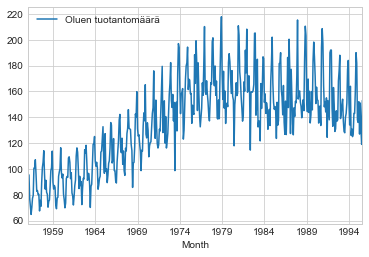

In [4]:
df = df.rename(columns = {'Monthly beer production': 'Oluen tuotantomäärä'})
df.plot()

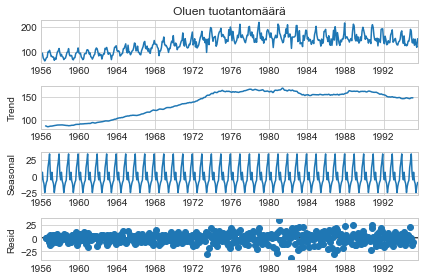

In [5]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu
# Alimmassa aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuorokausidatasta, niin kausivaihtelu esiintyy neljän havainnon (40 päivän) jaksoissa.
decompose = seasonal_decompose(df['Oluen tuotantomäärä']).plot()

In [6]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.
#freq-parametrille käytän arvoa 'MS', koska kyseessä ovat kuukauden ensimmäiset päivät. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Oluen tuotantomäärä'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 4, freq='MS').fit()

In [7]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Oluen tuotantomäärä,Ennuste
Month,,
1956-01-01,93.2,92.945001
1956-02-01,96.0,92.563900
1956-03-01,95.2,102.877441
1956-04-01,77.1,98.646052
1956-05-01,70.9,76.315748
...,...,...
1995-04-01,127.0,153.468992
1995-05-01,151.0,123.374088
1995-06-01,130.0,142.362807


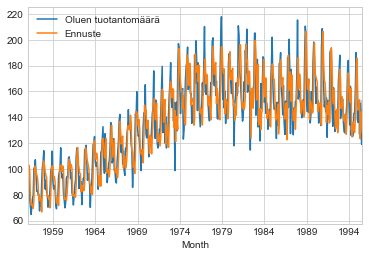

In [8]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [9]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Oluen tuotantomäärä,Ennuste,Ennustevirhe
Month,,,
1956-01-01,93.2,92.945001,0.254999
1956-02-01,96.0,92.563900,3.436100
1956-03-01,95.2,102.877441,-7.677441
1956-04-01,77.1,98.646052,-21.546052
1956-05-01,70.9,76.315748,-5.415748
...,...,...,...
1995-04-01,127.0,153.468992,-26.468992
1995-05-01,151.0,123.374088,27.625912
1995-06-01,130.0,142.362807,-12.362807


Text(0, 0.5, 'Ennustevirhe')

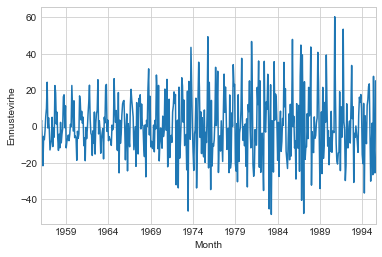

In [10]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

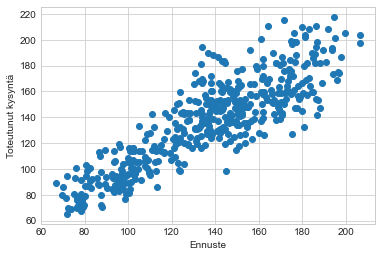

In [11]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Oluen tuotantomäärä'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [12]:
malli.summary()

Dep. Variable:,endog,No. Observations:,476
Model:,ExponentialSmoothing,SSE,139897.646
Optimized:,True,AIC,2721.226
Trend:,Additive,BIC,2754.550
Seasonal:,Multiplicative,AICC,2721.699
Seasonal Periods:,4,Date:,"Fri, 15 Jan 2021"
Box-Cox:,False,Time:,16:01:00
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7190134,alpha,True
smoothing_slope,2.8162e-18,beta,True


In [13]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Oluen tuotantomäärä,Ennuste,Ennustevirhe
Month,,,
1995-04-01,127.0,153.468992,-26.468992
1995-05-01,151.0,123.374088,27.625912
1995-06-01,130.0,142.362807,-12.362807
1995-07-01,119.0,144.483706,-25.483706
1995-08-01,153.0,127.826734,25.173266


In [14]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('1995-09-01', periods = 12, freq = 'MS')

# Ennusteet 12 kuukaudelle
ennusteet = malli.forecast(12)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
1995-09-01,133.916772
1995-10-01,133.099797
1995-11-01,144.078907
1995-12-01,145.979813
1996-01-01,133.965556
1996-02-01,133.148279
1996-03-01,144.131384
1996-04-01,146.032977
1996-05-01,134.014340
1996-06-01,133.196762


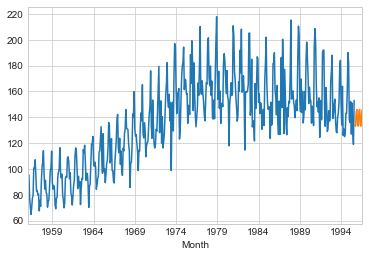

In [15]:
# Viivakaavio havainnoista
df['Oluen tuotantomäärä'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [16]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Oluen tuotantomäärä,Ennuste,Ennustevirhe
1956-01-01,93.2,92.945001,0.254999
1956-02-01,96.0,92.563900,3.436100
1956-03-01,95.2,102.877441,-7.677441
1956-04-01,77.1,98.646052,-21.546052
1956-05-01,70.9,76.315748,-5.415748
...,...,...,...
1996-04-01,NaN,146.032977,NaN
1996-05-01,NaN,134.014340,NaN
1996-06-01,NaN,133.196762,NaN
1996-07-01,NaN,144.183860,NaN
